In [2]:
import numpy as np 
import pandas as pd

data = pd.read_excel("E:/Users10/user/Desktop/mag/iad/labi/data/data_homework_sep.xlsx")

В предыдущей лабораторной работе мы уже выяснили, что представляют из себя наши данные. Помним, что пустых значений нет. Интересно посмотреть, сколько игрков представлено в выборке

In [3]:
a = len(data['player_id'].unique())
print(a)

513


у нас есть данные по 513 игрокам.Столбцы "Дата" и "Номер патча" нам ничем не помогут спрогнозировать победителя, мы их удалим

In [4]:
del data['dt']
del data['patch']

Можно предположить, что вероятнсть спасения и выигрыш зависят от оружия

In [5]:
data.pivot_table('player_id', 'item_class', 'is_surv', 'count').plot(kind='bar', stacked=True)

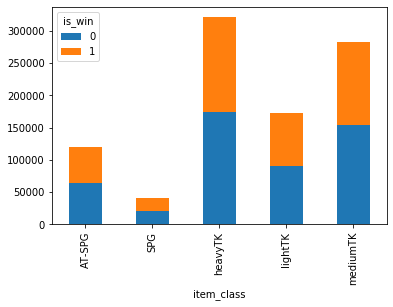

In [6]:
data.pivot_table('player_id', 'item_class', 'is_win', 'count').plot(kind='bar', stacked=True)

Теперь посмотрим, как страна происхождения влияет на вероятность спасения и выигрыша

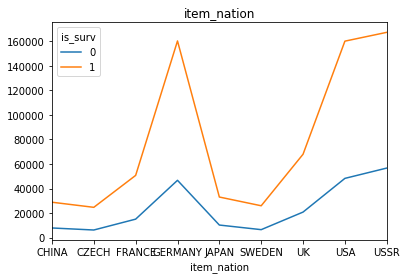

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

data.pivot_table('player_id', ['item_nation'], 'is_surv', 'count').plot(title='item_nation')

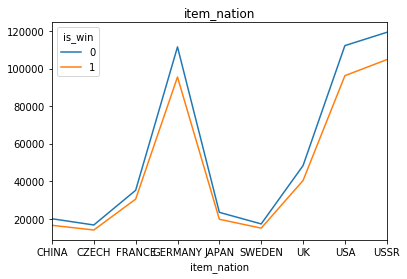

In [8]:
data.pivot_table('player_id', ['item_nation'], 'is_win', 'count').plot(title='item_nation')

Можно сделать вывод, что вероятность выживания больше зависит от страны, чем вероятность победы

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936961 entries, 0 to 936960
Data columns (total 9 columns):
player_id      936961 non-null int64
item_nation    936961 non-null object
item_class     936961 non-null object
item_level     936961 non-null int64
kills_made     936961 non-null int64
credits        936961 non-null int64
exp            936961 non-null int64
is_surv        936961 non-null int64
is_win         936961 non-null int64
dtypes: int64(7), object(2)
memory usage: 64.3+ MB


Нулевых данных у нас нет (сначала написать про прошлую лабу - нет нулевых)

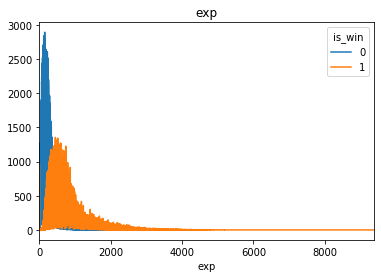

In [10]:
data.pivot_table('player_id', ['exp'], 'is_win', 'count').plot(title='exp')

Видим, что вероятность победить сильно зависит от опыта, что логично

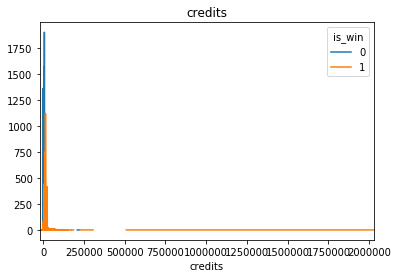

In [11]:
data.pivot_table('player_id', ['credits'], 'is_win', 'count').plot(title='credits')

Также вероятность победить зависит от суммы полученных кредитов (или наоборот)

Предварительный анализ данных завершен, и по его результатам у нас получилась некая выборка, в которой содержатся несколько полей, и вроде бы можно преступить к построению модели, если бы не одно «но»: наши данные содержат не только числовые, но и текстовые данные.

Поэтому перед тем, как строить модель, нужно закодировать все наши текстовые значения.

Можно это сделать вручную, а можно с помощью модуля sklearn.preprocessing. Давайте воспользуемся вторым вариантом.

Закодировать список с фиксированными значениями можно с помощью объекта LabelEncoder(). Суть данной функции заключается в том, что на вход ей подается список значений, который надо закодировать, на выходе получается список классов, индексы которых и являются кодами элементов поданного на вход списка.

В итоге наши исходные данные будут выглядеть так:

In [12]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

dicts = {}
label.fit(data.item_class.drop_duplicates()) #задаем список значений для кодирования

dicts['item_class'] = list(label.classes_)

data.item_class = label.transform(data.item_class) #заменяем значения из списка кодами закодированных элементов
label.fit(data.item_nation.drop_duplicates())

dicts['item_nation'] = list(label.classes_)

data.item_nation = label.transform(data.item_nation)

data.item_nation[:10]

0    8
1    7
2    8
3    2
4    0
5    8
6    8
7    2
8    3
9    2
Name: item_nation, dtype: int32

In [25]:
test = pd.read_excel("E:/Users10/user/Desktop/mag/iad/labi/data/data_homework_sep.xlsx")

result = DataFrame(test.player_id)
test = test.drop(['dt','patch','player_id'],axis=1)

label.fit(dicts['item_class'])
test.item_class = label.transform(test.item_class)

label.fit(dicts['item_nation'])
test.item_nation = label.transform(test.item_nation)

Построение моделей классификации и их анализ
Ну что же, данные обработаны и можно приступить к построению модели, но для начала нужно определиться с тем, как мы будем проверять точность полученной модели. Для данной проверки мы будем использовать скользящий контроль и ROC-кривые. Проверку будем выполнять на обучающей выборке, после чего применим ее на тестовую.

In [26]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import cross_validate, train_test_split, cross_val_score

from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc

import pylab as pl

Для начала, надо разделить нашу обучающую выборку на показатель, который мы исследуем, и признаки, его определяющие:

In [27]:
target = data.is_win

train = data.drop(['is_win'], axis=1) #из исходных данных убираем Id пассажира и флаг спасся он или нет

kfold = 5 #количество подвыборок для валидации

itog_val = {} #список для записи результатов кросс-валидации разных алгоритмов

Теперь наша обучающая выборка выглядит так:

In [28]:
train.head()

,player_id,item_nation,item_class,item_level,kills_made,credits,exp,is_surv
0,1813476,8,0,5,0,12057,369,1
1,1722910,7,3,9,0,21192,917,0
2,1795566,8,2,8,0,8213,80,1
3,1717262,2,3,9,1,23606,1073,1
4,1714046,0,2,8,1,33086,395,1


Теперь разобьем показатели, полученные ранее, на 2 подвыборки (обучающую и тестовую) для расчета ROC кривых (для скользящего контроля этого делать не надо, т.к. функция проверки это делает сама). В этом нам поможет функция train_test_split модуля cross_validation:

In [29]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = train_test_split(train, target, test_size=0.25)

В качестве параметров ей передается:

Массив параметров

Массив значений показателей

Соотношение, в котором будет разбита обучающая выборка (в нашем случае для тестового набора будет выделена 1/4 часть данных исходной обучающей выборки)

На выходе функция выдает 4 массива:

Новый обучающий массив параметров

тестовый массив параметров

Новый массив показателей

тестовый массив показателей

Далее представлены перечисленные методы с наилучшими параметрами, подобранные опытным путем:

In [30]:
model_rfc = RandomForestClassifier(n_estimators = 70) 

model_knc = KNeighborsClassifier(n_neighbors = 18) 

model_lr = LogisticRegression(penalty='l1', tol=0.01)

model_svc = svm.SVC() #по умолчанию kernek='rbf'

Теперь проверим полученные модели с помощью скользящего контроля. Для этого нам необходимо воcпользоваться функцией cross_val_score: (SVC строить не будем, слишком долго)

In [31]:
warnings.filterwarnings("ignore", category=FutureWarning)

scores = cross_val_score(model_rfc, train, target, cv = kfold)

itog_val['RandomForestClassifier'] = scores.mean()

scores = cross_val_score(model_knc, train, target, cv = kfold)

itog_val['KNeighborsClassifier'] = scores.mean()

scores = cross_val_score(model_lr, train, target, cv = kfold)

itog_val['LogisticRegression'] = scores.mean()


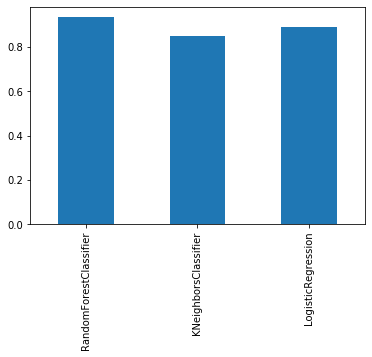

In [32]:
from pandas import DataFrame
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

лучшей оказалась модель RandomForest. Теперь посмотрим на графики ROC-кривых для оценки точности работы классификатора. Графики будем рисовать с помощью библиотеки matplotlib:

<Figure size 432x288 with 0 Axes>

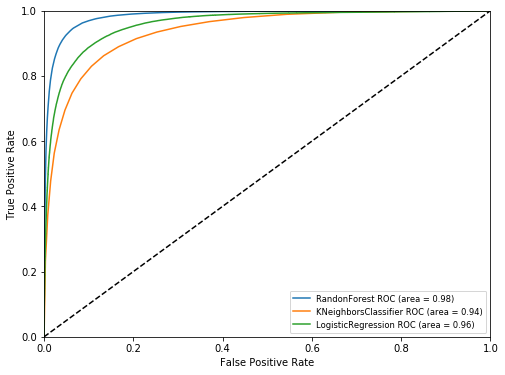

In [33]:
pl.clf()

plt.figure(figsize=(8,6))


#RandomForestClassifier

probas = model_rfc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)

fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])

roc_auc = auc(fpr, tpr)

pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandonForest',roc_auc))

#KNeighborsClassifier

probas = model_knc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)

fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])

roc_auc = auc(fpr, tpr)

pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

#LogisticRegression

probas = model_lr.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)

fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])

roc_auc = auc(fpr, tpr)

pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))

pl.plot([0, 1], [0, 1], 'k--')

pl.xlim([0.0, 1.0])

pl.ylim([0.0, 1.0])

pl.xlabel('False Positive Rate')

pl.ylabel('True Positive Rate')

pl.legend(loc=0, fontsize='small')

pl.show()

Лучший результат снова показал RandomForest. Теперь осталось только применить нашу модель к тестовой выборке

In [36]:
model_rfc.fit(train, target)

result.insert(1,'is_win', model_rfc.predict(test))

result.to_csv('E:/Users10/user/Desktop/mag/iad/labi/data/test.csv', index=False)